Uncomment the following cell to install necessary dependencies for the demo

In [ ]:
# If you setup the environment using `uv sync`, uncommenting the following is not necessary:
#!pip install seaborn optax datasets einops

In [ ]:
import os

# Choose which gpu to use for JAX and how much memory to reserve
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="0.5" # Defaults to 0.9 * TOTAL_MEM

In [ ]:
from typing import *
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import jax.random as jr
import equinox as eqx
import bbhamux as hmx
from bbhamux import Neurons, HAM

# Quick testing

In [ ]:
class SimpleSynapse(eqx.Module):
    W: jax.Array
    shape: Tuple[int]
    
    def __init__(self, key, shape):
        self.shape = shape
        self.W = jax.random.normal(key, shape)
        
    def __call__(self, g1, g2):
        return g1 @ self.W @ g2

key = jax.random.PRNGKey(0)
nhid = 9
nlabel = 8
ninput = 7

neurons = {
    "input": Neurons(hmx.lagr_identity, ninput),
    "labels": Neurons(hmx.lagr_softmax, nlabel),
    "hidden": Neurons(hmx.lagr_softmax, nhid)
}

synapses = {
    "dense1": SimpleSynapse(key, (ninput, nhid)),
    "dense2": SimpleSynapse(key, (nlabel, nhid))
}

connections = [
    (("input", "hidden"), "dense1"),
    (("labels", "hidden"), "dense2")
]

ham = HAM(neurons, synapses, connections)

In [ ]:
xs = ham.init_states() # No batch size
gs = ham.activations(xs)

print(ham.energy_tree(gs, xs))
print(ham.energy(gs, xs))
print(ham.dEdg(gs, xs))

{'neurons': {'input': Array(0., dtype=float32), 'labels': Array(-2.0794415, dtype=float32), 'hidden': Array(-2.1972246, dtype=float32)}, 'connections': [Array(0., dtype=float32), Array(0.03434035, dtype=float32)]}
-4.242326
{'hidden': Array([ 0.3526293 ,  0.16032803, -1.0948389 ,  0.2121184 ,  0.12415937,
       -0.09627381,  0.24909379,  0.19427297,  0.20757398], dtype=float32), 'input': Array([ 0.3336807 ,  0.46093288,  0.05512287, -0.23834947, -0.06752507,
       -0.18589741, -0.2104522 ], dtype=float32), 'labels': Array([ 0.3336807 ,  0.46093288,  0.05512287, -0.23834947, -0.06752507,
       -0.18589741, -0.2104522 ,  0.12721057], dtype=float32)}


In [ ]:
vham = ham.vectorize()
xs = vham.init_states(3) # Batch size 3
gs = vham.activations(xs)

print(vham.energy_tree(gs, xs))
print(vham.energy(gs, xs))
print(vham.dEdg(gs, xs))

ham = vham.unvectorize()

{'connections': [Array([0., 0., 0.], dtype=float32), Array([0.03434035, 0.03434035, 0.03434035], dtype=float32)], 'neurons': {'hidden': Array([-2.1972246, -2.1972246, -2.1972246], dtype=float32), 'input': Array([0., 0., 0.], dtype=float32), 'labels': Array([-2.0794415, -2.0794415, -2.0794415], dtype=float32)}}
[-4.242326 -4.242326 -4.242326]
{'hidden': Array([[ 0.3526293 ,  0.16032803, -1.0948389 ,  0.2121184 ,  0.12415937,
        -0.09627381,  0.24909379,  0.19427297,  0.20757398],
       [ 0.3526293 ,  0.16032803, -1.0948389 ,  0.2121184 ,  0.12415937,
        -0.09627381,  0.24909379,  0.19427297,  0.20757398],
       [ 0.3526293 ,  0.16032803, -1.0948389 ,  0.2121184 ,  0.12415937,
        -0.09627381,  0.24909379,  0.19427297,  0.20757398]],      dtype=float32), 'input': Array([[ 0.3336807 ,  0.46093288,  0.05512287, -0.23834947, -0.06752507,
        -0.18589741, -0.2104522 ],
       [ 0.3336807 ,  0.46093288,  0.05512287, -0.23834947, -0.06752507,
        -0.18589741, -0.2104522

# Check energy descent

In [ ]:
import optax

class DenseSynapse(eqx.Module):
    W: jax.Array
    def __init__(self, key, d1:int, d2:int):
        super().__init__()
        self.W = jax.random.normal(key, (d1, d2)) * 0.4
        
    def __call__(self, g1, g2):
        """Compute the energy of the synapse"""
        return -jnp.einsum("...k,...k->...", g1 @ self.W, g2)

In [ ]:
key = jax.random.PRNGKey(0)
neurons = {
    "input": hmx.Neurons(hmx.lagr_layernorm, (33,)),
    "hidden": hmx.Neurons(hmx.lagr_softmax, (22,))
}
synapses = {
    "s1": DenseSynapse(key, 33, 22),
}
connections = [
    (["input", "hidden"], "s1")
]
ham = hmx.HAM(neurons, synapses, connections)

xs = ham.init_states()
xs = {k: 30*jax.random.normal(key, xs[k].shape) for k in xs.keys()}
gs = ham.activations(xs)

xopt = optax.sgd(5e-1)
optstate = xopt.init(xs)

In [ ]:
@eqx.filter_jit
def new_dedg(ham, xs):
    gs = ham.activations(xs)
    energy, dEdg = ham.dEdg(gs, xs, return_energy=True)
    return energy, dEdg

In [ ]:
nsteps = 50
energies = jnp.empty(nsteps)
for i in range(nsteps):
    energy, dEdg = new_dedg(ham, xs)
    energies = energies.at[i].set(energy)

    # xs = jtu.tree_map(lambda x, u: x - 0.5 * u, xs, dEdg)
    updates, optstate = xopt.update(dEdg, optstate, xs)
    xs = optax.apply_updates(xs, updates)

<Axes: >

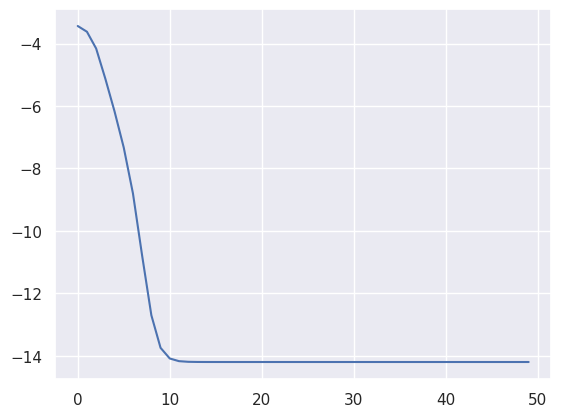

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

sns.lineplot(x=jnp.arange(nsteps), y=jnp.stack(energies))

# Train on MNIST

A quick training run to confirm that things work. A lot of optimization needed.

In [ ]:
import datasets
from einops import rearrange
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm

In [ ]:
def get_mnist_train_test():
    Xtrain_path, Xtest_path = Path("data/Xtrain_mnist.npy"), Path("data/Xtest_mnist.npy")
    if not Xtrain_path.exists() or not Xtest_path.exists():
        print("Downloading MNIST data...")
        mnist = datasets.load_dataset("mnist").with_format("numpy")
        train_set = mnist['train']
        test_set = mnist['test']

        print("Saving Xtrain...")
        Xtrain = next(train_set.iter(len(train_set)))['image']
        np.save(Xtrain_path, Xtrain)
        print("Saving Xtest...")
        Xtest = next(test_set.iter(len(test_set)))['image']
        np.save(Xtest_path, Xtest)
        print("Done")
    
    Xtrain, Xtest = np.load(Xtrain_path), np.load(Xtest_path)
    return Xtrain, Xtest

In [ ]:
def transform(x):
    x = x / 255.
    x = rearrange(x, "... h w -> ... (h w)") 
    x = x / jnp.sqrt((x ** 2).sum(-1, keepdims=True))
    return x

Xtrain, Xtest = get_mnist_train_test()
Xtest = transform(Xtest)
Xtrain = transform(Xtrain)

In [ ]:
# set the colormap and centre the colorbar
class MidpointNormalize(mpl.colors.Normalize):
    """Normalise the colorbar."""
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))
    
cnorm=MidpointNormalize(midpoint=0.)

def show_img(img):
    vmin, vmax = img.min(), img.max()
    vscale = max(np.abs(vmin), np.abs(vmax))
    cnorm = MidpointNormalize(midpoint=0., vmin=-vscale, vmax=vscale)
    
    fig, ax = plt.subplots(1,1)
    pcm = ax.imshow(img, cmap="seismic", norm=cnorm)
    ax.axis("off")
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.83, 0.15, 0.03, 0.7])
    fig.colorbar(pcm, cax=cbar_ax);
    return fig

In [ ]:
class DenseSynapseHid(eqx.Module):
    W: jax.Array
    def __init__(self, key, d1:int, d2:int):
        super().__init__()
        self.W = jax.random.normal(key, (d1, d2)) * 0.02 + 0.2
        
    @property
    def nW(self):
        nc = jnp.sqrt(jnp.sum(self.W ** 2, axis=0, keepdims=True))
        return self.W / nc
        
    def __call__(self, g1):
        """Compute the energy of the synapse"""
        x2 = g1 @ self.nW
        beta = 1e1
        return - 1/beta *  jax.nn.logsumexp(beta * x2, axis=-1)
    
key = jax.random.PRNGKey(0)
neurons = {
    "input": hmx.Neurons(hmx.lagr_spherical_norm, (784,)),
}
synapses = {
    "s1": DenseSynapseHid(key, 784, 900),
}
connections = [
    (["input"], "s1")
]

ham = hmx.HAM(neurons, synapses, connections)
xs = ham.init_states()
gs = ham.activations(xs)
opt = optax.adam(4e-2)

In [ ]:
n_epochs = 10
pbar = tqdm(range(n_epochs), total=n_epochs)
img = Xtrain[:]
batch_size = 100

ham = ham.vectorize()
opt_state = opt.init(eqx.filter(ham, eqx.is_array))


def lossf(ham, xs,key, nsteps=1, alpha=1.):
    """Given a noisy initial image, descend the energy and try to reconstruct the original image at the end of the dynamics.
    
    Works best with fewer steps due to vanishing gradient problems"""
    img = xs['input']
    xs['input'] = img + jr.normal(key, img.shape) * 0.3
    
    for i in range(nsteps):
        # Construct noisy image to final prediction
        gs = ham.activations(xs)
        evalue, egrad = ham.dEdg(gs, xs, return_energy=True)
        xs = jtu.tree_map(lambda x, dEdg: x - alpha * dEdg, xs, egrad)

    gs = ham.activations(xs)
    img_final = gs['input']
    loss = ((img_final - img)**2).mean()
    
    logs = {
        "loss": loss,
    }
    
    return loss, logs

@eqx.filter_jit
def step(img, ham, opt_state, key):
    xs = ham.init_states(bs=img.shape[0])
    xs["input"] = img

    (loss, logs), grads = eqx.filter_value_and_grad(lossf, has_aux=True)(ham, xs, key)
    updates, opt_state = opt.update(grads, opt_state, ham)
    newparams = optax.apply_updates(eqx.filter(ham, eqx.is_array), updates)
    ham = eqx.combine(newparams, ham)
    return ham, opt_state, logs
    
noise_rng = jr.PRNGKey(100)
batch_rng = jr.PRNGKey(10)
for e in pbar:
    batch_key, batch_rng = jr.split(batch_rng)
    idxs = jr.permutation(batch_key, jnp.arange(img.shape[0]))
    i = 0

    while i < img.shape[0]:
        noise_key, noise_rng = jr.split(noise_rng)
        batch = img[idxs[i: i+batch_size]]
        ham, opt_state, logs = step(batch, ham, opt_state, noise_key)
        i = i+batch_size

        pbar.set_description(f'[{i}]: epoch = {e+1:03d}/{n_epochs:03d}, loss = {logs["loss"].item():2.6f}')

[60000]: epoch = 010/010, loss = 0.000728: 100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


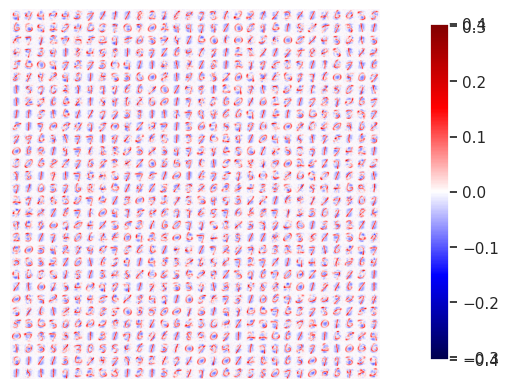

In [ ]:
# The above architecture trains ok, learns some decent prototypes. Not perfect
myW = ham.synapses["s1"].nW
kh = kw = int(np.sqrt(myW.shape[-1]))
show_img(rearrange(myW, "(h w) (kh kw) -> (kh h) (kw w)", h=28, w=28, kh=kh, kw=kw));